In [156]:
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision import models
from PIL import Image
import xml.etree.ElementTree as ET

In [157]:
main_dir = '/zhome/97/a/203937/02516_poster_3/'
img_dir = main_dir + 'Potholes/annotated-images/'
proposal_file_path = main_dir + 'labeled_proposals_edge_boxes.json'
split_file_path = main_dir + 'Potholes/splits.json'

# Make sure the above paths are correct
assert os.path.exists(main_dir), f"Main directory does not exist: {main_dir}"
assert os.path.exists(img_dir), f"Image directory does not exist: {img_dir}"
assert os.path.exists(proposal_file_path), f"Proposal file does not exist: {proposal_file_path}"
assert os.path.exists(split_file_path), f"Split file does not exist: {split_file_path}"
print("All paths are verified and exist.")

All paths are verified and exist.


In [158]:
with open(proposal_file_path, 'r') as f:
    proposals = json.load(f)

In [159]:
class PotholeDatasetFromProposals(Dataset):
    def __init__(self, image_file_list, img_dir, proposals, transform=None):
        self.image_file_list = image_file_list
        self.img_dir = img_dir
        self.proposals = proposals
        self.transform = transform
        self.new_size = next((t.size for t in transform.transforms if isinstance(t, T.Resize)), None)

    def __len__(self):
        return len(self.image_file_list)

    def __getitem__(self, idx):
        img_name = self.image_file_list[idx]
        image_path = os.path.join(self.img_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        original_size = image.size

        scale_x, scale_y = (self.new_size[0] / original_size[0], self.new_size[1] / original_size[1]) if self.new_size else (1.0, 1.0)

        boxes, labels = self._get_proposals(img_name, scale_x, scale_y)

        if not boxes:  # No potholes found
            boxes, labels = self._add_from_xml(img_name, scale_x, scale_y)
        else:
            xml_boxes, xml_labels = self._add_from_xml(img_name, scale_x, scale_y)
            boxes += xml_boxes
            labels += xml_labels

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, {'boxes': boxes, 'labels': labels}

    def _get_proposals(self, img_name, scale_x, scale_y):
        boxes, labels = [], []
        at_least_one_pothole = False

        for proposal in self.proposals.get(img_name, []):
            xmin_resized, ymin_resized = int(proposal["x"] * scale_x), int(proposal["y"] * scale_y)
            xmax_resized, ymax_resized = int((proposal["x"] + proposal["width"]) * scale_x), int((proposal["y"] + proposal["height"]) * scale_y)

            boxes.append([xmin_resized, ymin_resized, xmax_resized, ymax_resized])
            label = 1 if proposal['label'] == "pothole" else 0
            labels.append(label)

            if label == 1:
                at_least_one_pothole = True

        # Ensure that we return empty boxes and labels if no pothole was found
        return (boxes, labels) if at_least_one_pothole else ([], [])

    def _add_from_xml(self, img_name, scale_x, scale_y):
        xml_file = img_name.replace('.jpg', '.xml')
        tree = ET.parse(os.path.join(self.img_dir, xml_file))
        root = tree.getroot()

        boxes, labels = [], []
        for obj in root.findall("object"):
            if obj.find("name").text == "pothole":
                bbox = obj.find("bndbox")
                xmin, ymin, xmax, ymax = map(int, (bbox.find("xmin").text, bbox.find("ymin").text, bbox.find("xmax").text, bbox.find("ymax").text))
                xmin_resized, ymin_resized = int(xmin * scale_x), int(ymin * scale_y)
                xmax_resized, ymax_resized = int(xmax * scale_x), int(ymax * scale_y)
                # Remove boxes with zero area
                if xmin_resized == xmax_resized or ymin_resized == ymax_resized:
                    continue
                boxes.append([xmin_resized, ymin_resized, xmax_resized, ymax_resized])
                labels.append(1)

        return boxes, labels


In [160]:
image_file_list = list(proposals.keys())  # Image files in the proposals

# Define transformations
transform = T.Compose([
    T.Resize((128, 128)), # FOR NOW ALIGN WITH THE PROPOSALS, CHANGE DATALOADERS TO ALIGN WITH THE TRANSFORM
    T.ToTensor()
])

# Initialize dataset with only proposals
dataset = PotholeDatasetFromProposals(
    image_file_list=image_file_list,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# # Example loop to access batched data
# for images, targets in dataloader:
#     print("Batch of images:", images)
#     print("Batch of targets:", targets)
#     break  # Display only the first batch


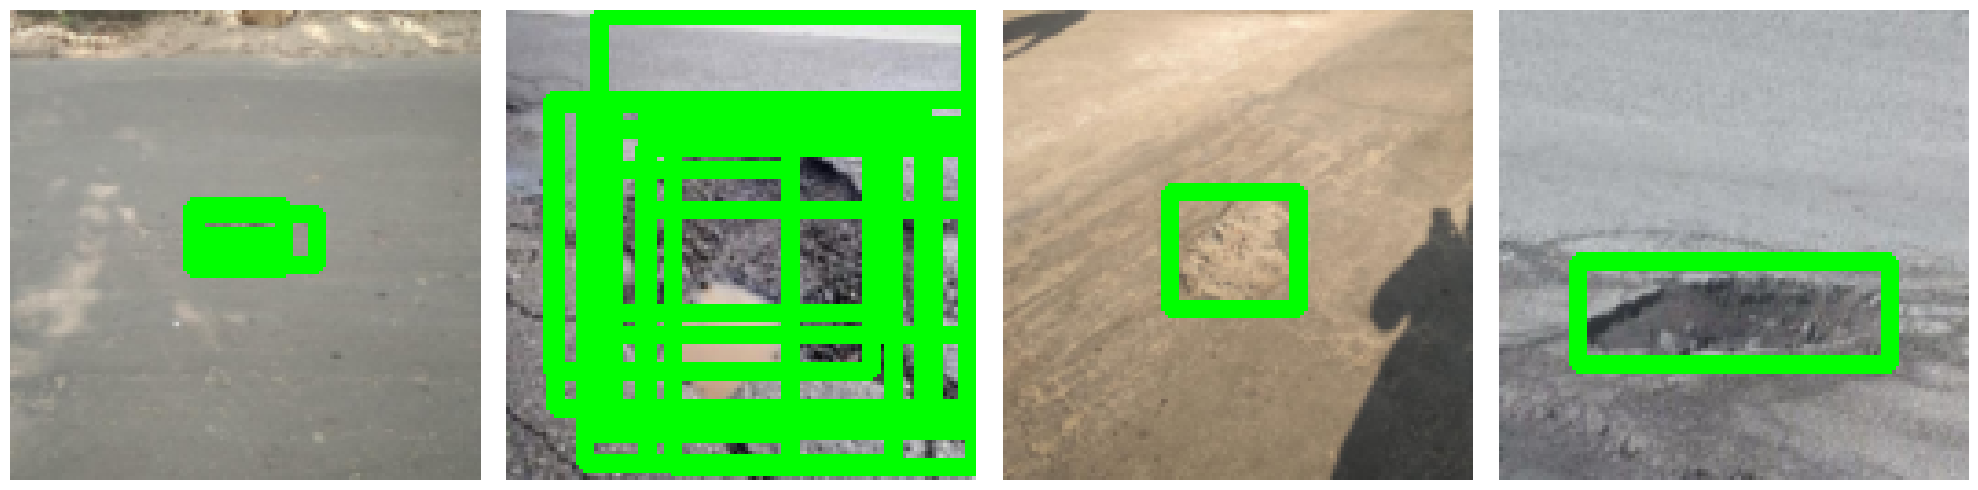

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_images(images, targets, denormalize=False):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    
    for i, (image, target) in enumerate(zip(images, targets)):
        # Convert image to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) and move to CPU if necessary
        if denormalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean  # Denormalize
            image = np.clip(image, 0, 1)  # Clip to [0, 1] range for display
        
        image = (image * 255).astype(np.uint8)
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw bounding boxes on the BGR image
        for box, label in zip(target['boxes'], target['labels']):
            x_min, y_min, x_max, y_max = box.numpy().astype(int)
            
            color = (0, 0, 255) if label == 0 else (0, 255, 0)
            
            if label == 1:
                image_bgr = cv2.rectangle(image_bgr, (x_min, y_min), (x_max, y_max), color, 3)
        
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first batch of images
images, targets = next(iter(dataloader))
plot_images(images, targets)


In [162]:
# open file splits.json which contains the train and test split


with open(split_file_path, 'r') as f:
    splits = json.load(f)

# Get the train and test splits
train_files = splits['train']
test_files = splits['test']

# Change .xml to .jpg
train_files = [f.replace('.xml', '.jpg') for f in train_files]
test_files = [f.replace('.xml', '.jpg') for f in test_files]

print(f"Number of training images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

Number of training images: 532
Number of test images: 133


In [163]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.9 # 80% training data
val_ratio = 0.1 # 10% validation data

# Split the training data into training and validation sets
train_files, val_files = train_test_split(train_files, test_size=val_ratio, random_state=42)

print(f"Number of training images: {len(train_files)}")
print(f"Number of validation images: {len(val_files)}")
print(f"Number of test images: {len(test_files)}")

# Define the datasets using the split files
train_dataset = PotholeDatasetFromProposals(
    image_file_list=train_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

val_dataset = PotholeDatasetFromProposals(
    image_file_list=val_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

test_dataset = PotholeDatasetFromProposals(
    image_file_list=test_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)


Number of training images: 478
Number of validation images: 54
Number of test images: 133


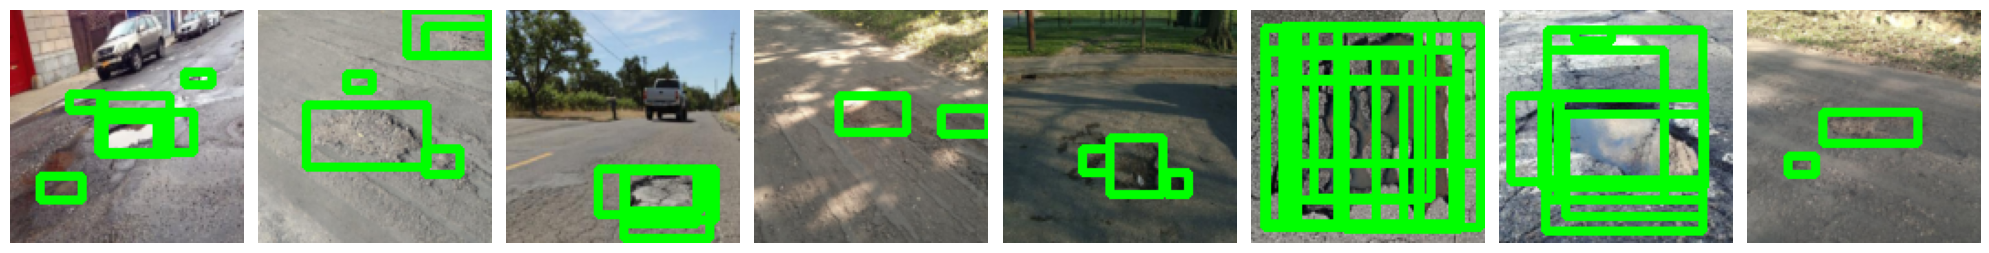

In [164]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Display the first batch of images
images, targets = next(iter(train_loader))
plot_images(images, targets)



In [165]:
# Load the pre-trained Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set model to evaluation mode for inference

num_classes = 2  # 1 class (pothole) + 1 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

from torch.optim import Adam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model.to(device)

# Optimizer for Faster R-CNN
optimizer = Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        # Move to GPU if available
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass

        # check if size of bb is correct (not 0 width or height)
        for target in targets:
            boxes = target['boxes']
            labels = target['labels']
            for i, box in enumerate(boxes):
                x_min, y_min, x_max, y_max = box
                if x_min == x_max or y_min == y_max:
                    print(f"Invalid box: {box}, labels: {labels[i]}")
                    print(f"Image shape: {images[0].shape}")
                    print(f"Image that caused the error: {images[0]}")

        loss_dict = model(images, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")



Using device: cuda


Epoch 1/10, Loss: 0.7477976083755493
Epoch 2/10, Loss: 0.7137595415115356
Epoch 3/10, Loss: 0.70036780834198
Epoch 4/10, Loss: 0.7095754742622375
Epoch 5/10, Loss: 0.5816147923469543
Epoch 6/10, Loss: 0.7445632219314575
Epoch 7/10, Loss: 0.5186970233917236
Epoch 8/10, Loss: 0.4769914746284485
Epoch 9/10, Loss: 0.25448429584503174
Epoch 10/10, Loss: 0.42956823110580444


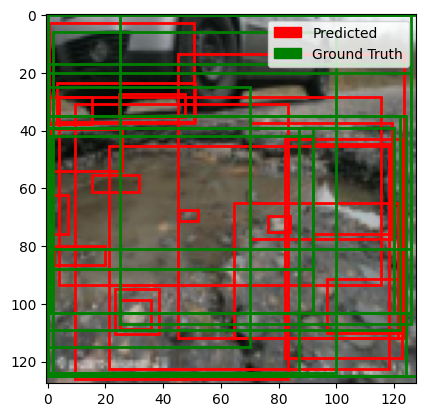

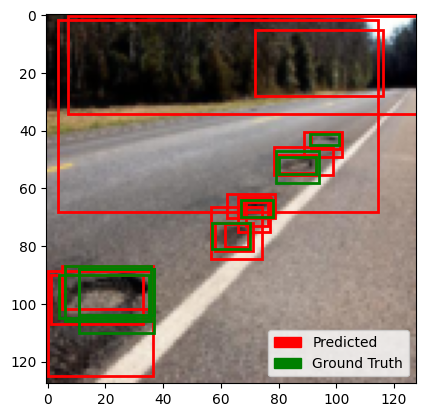

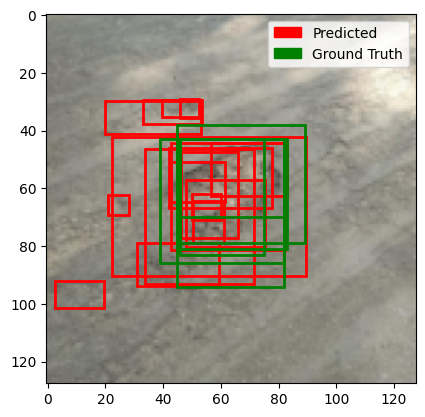

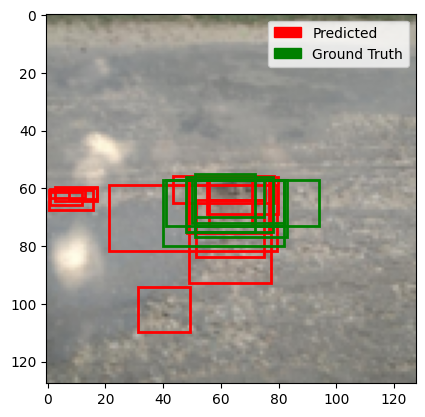

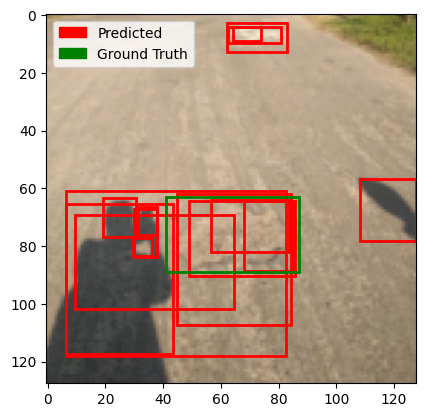

Average IoU for class 1 (potholes) on test set: 0.32


In [166]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import box_iou

# Set IoU threshold and define the class label for potholes
IOU_THRESHOLD = 0.5
TARGET_CLASS_LABEL = 1  # Replace with the class ID for potholes

# Function to calculate IoU for evaluation, only considering boxes of the target class
def calculate_iou(pred_boxes, true_boxes):
    if len(pred_boxes) == 0 or len(true_boxes) == 0:
        return torch.tensor(0.0)
    # Calculate IoU for each pair of boxes and return the max IoU for each true box
    ious = box_iou(pred_boxes, true_boxes)
    return ious.diag().mean().item()  # Return the mean IoU

# Run inference, calculate IoU, and visualize results with class filtering
def evaluate_and_visualize(model, test_loader, device, limit=5):
    model.eval()  # Set the model to evaluation mode
    iou_scores = []
    evaluated_images = 0
    
    with torch.no_grad():  # Disable gradient computation
        for images, targets in test_loader:
            if evaluated_images >= limit:
                break
            
            # Move images and targets to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Run inference
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                if evaluated_images >= limit:
                    break
                
                # Filter boxes by the target class label
                pred_boxes = output['boxes'][output['labels'] == TARGET_CLASS_LABEL].cpu()
                true_boxes = targets[i]['boxes'][targets[i]['labels'] == TARGET_CLASS_LABEL].cpu()
                
                # Calculate IoU for the target class only
                iou = calculate_iou(pred_boxes, true_boxes)
                iou_scores.append(iou)
                
                # Visualize results with bounding boxes
                visualize_results(images[i].cpu(), pred_boxes, true_boxes)
                
                evaluated_images += 1
    
    # Calculate and print the average IoU for the target class
    mean_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0
    print(f"Average IoU for class {TARGET_CLASS_LABEL} (potholes) on test set: {mean_iou:.2f}")

# Function to visualize an image with bounding boxes
def visualize_results(image, pred_boxes, true_boxes):
    fig, ax = plt.subplots(1)
    # Convert image tensor to numpy
    img = image.permute(1, 2, 0).numpy()
    ax.imshow(img)
    
    # Plot predicted boxes for the target class in red
    for box in pred_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
    
    # Plot ground truth boxes for the target class in green
    for box in true_boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor="g", facecolor="none"
        )
        ax.add_patch(rect)
    
    # add legend red for predicted and green for ground truth
    red_patch = patches.Patch(color='red', label='Predicted')
    green_patch = patches.Patch(color='green', label='Ground Truth')
    ax.legend(handles=[red_patch, green_patch])
    plt.show()

# Evaluate and visualize
evaluate_and_visualize(model, test_loader, device)
